<a href="https://colab.research.google.com/github/hylle77/BDS/blob/main/Group_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Assignment 2: TRANSFORMER MODELS


## Nesscary installations and imports

In [ ]:
#Nesscary installations
!pip install transformers --q
!pip install -U sentence_transformers --q
!pip install Gradio --q
!pip install datasets --q
!pip install transformers matplotlib --q

In [2]:
#Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from IPython.display import display, HTML
from sentence_transformers import SentenceTransformer, util
import pickle
import os
import gradio as gr
from datasets import load_dataset
from transformers import BertTokenizer, BertModel

## Part 1: SBERT and Semantic Search


### Loading the dataset



In [3]:
#Loading the dataset
df = pd.read_csv('https://raw.githubusercontent.com/hylle77/BDS/main/Assignment%202/giphy.csv')

### Data exploration and preprocessing

In [4]:
#First look at the dataset
df.head()

,GIF ID,Web Archive Link,MD5 Hash,File Size (In Bytes),GIPHY Title,Import Date,Trending Date
0,1000eGIbYHercI,http://webarchive.loc.gov/all/20150318155641/h...,245bd1a346bf15da905a7acfd1985d87,82505,slipper GIF,9/21/2013 3:37,1/1/1970 0:00
1,1000fHsBSKSL6w,http://webarchive.loc.gov/all/20150318155641/h...,a4328e5fcc99015f2cf04d533cadd06d,102564,swag hustling GIF,6/22/2015 5:35,1/12/2016 23:45
2,1000WjcUQeqOaY,http://webarchive.loc.gov/all/20150318155641/h...,1980e767b94acaf7978886989b755656,48315,jennifer lawrence salute GIF,3/22/2013 11:27,1/1/1970 0:00
3,1003Kuq13ICXDO,http://webarchive.loc.gov/all/20150318155641/h...,10b74b1cd9aaabbd259bc736d2be8db5,104921,love happy GIF,3/7/2016 22:08,0000-00-00 00:00:00
4,1004D5v8Dbe6cw,http://webarchive.loc.gov/all/20150318155641/h...,ce3d7602047cb9125d42e098a418ece1,45649,visual album beyonce GIF,12/13/2013 14:32,6/20/2014 7:15


In [5]:
#Display the shape of the dataset
print(df.shape)

#Display data types of each column
df.dtypes

(10972, 7)


GIF ID                  object
Web Archive Link        object
MD5 Hash                object
File Size (In Bytes)     int64
GIPHY Title             object
Import Date             object
Trending Date           object
dtype: object

In [6]:
#Check for missing values
df.isnull().sum()

GIF ID                    0
Web Archive Link          0
MD5 Hash                  0
File Size (In Bytes)      0
GIPHY Title             511
Import Date             316
Trending Date           316
dtype: int64

In [7]:
#Dropping missing values in 'GIPHY Title' and 'Web Archive Link' and converting them to a list
giphy_titles = df['GIPHY Title'].dropna().tolist()
web_links = df['Web Archive Link'].tolist()

### GIF Search Engine


In [8]:
#Initializing the CLIP model
model = SentenceTransformer('clip-ViT-B-32')

#Create Embeddings
img_emb = model.encode(giphy_titles, convert_to_tensor=True, show_progress_bar=True)

#Saving the embeddings and web links
emb_filename = 'giphy-embeddings.pkl'
with open(emb_filename, 'wb') as fOut:
    pickle.dump((web_links, img_emb), fOut)

print("Embeddings and web links have been saved")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.91k [00:00<?, ?B/s]

0_CLIPModel/config.json:   0%|          | 0.00/4.03k [00:00<?, ?B/s]

0_CLIPModel/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

0_CLIPModel/vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

0_CLIPModel/special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

0_CLIPModel/tokenizer_config.json:   0%|          | 0.00/604 [00:00<?, ?B/s]

0_CLIPModel/preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Batches:   0%|          | 0/327 [00:00<?, ?it/s]

Embeddings and web links have been saved


In [9]:
#Loading precomputed embeddings
use_precomputed_embeddings = True

if use_precomputed_embeddings:
    emb_filename = 'giphy-embeddings.pkl'
    if os.path.exists(emb_filename):
        with open(emb_filename, 'rb') as fIn:
            web_links, img_emb = pickle.load(fIn)
        print("Loaded embeddings for", len(web_links), "GIFs.")
    else:
        print("Embeddings file does not exist.")

Loaded embeddings for 10972 GIFs.


In [10]:
def search(query, k=3):
    # Encode the query (which is a text string) to get its embedding
    query_emb = model.encode([query], convert_to_tensor=True, show_progress_bar=False)

    #Using the util.semantic_search function, to computes the cosine-similarity between the query and all the image embeddings
    hits = util.semantic_search(query_emb, img_emb, top_k=k)[0]

    print("Query:")
    #Display the query as HTML
    display(HTML(f'<p>{query}</p>'))
    for hit in hits:
        #Retrieve the web link for the GIF
        gif_link = web_links[hit['corpus_id']]
        # Display the GIF using its web link
        display(HTML(f'<img src="{gif_link}" width="200" />'))

In [11]:
#Since the web links need verification to display in the notebook, manually opening a link first will bypass the GIFs not showing. (This is a dataset problem, sorry!)
for link in web_links[:1]:
    print(link)

http://webarchive.loc.gov/all/20150318155641/http://media.giphy.com/media/1000eGIbYHercI/giphy.gif


In [12]:
search("Cat doing funny things")

Query:


### Gradio Depolyment


In [13]:
#Adapted search function, smallere changes because of the HTML output-type Gradio accepts
def search(query, k=3):
    query_emb = model.encode([query], convert_to_tensor=True, show_progress_bar=False)
    hits = util.semantic_search(query_emb, img_emb, top_k=k)[0]

    #Initialize an empty string for the HTML content (GIFs)
    html_output = f"<div>Query: {query}</div>"
    for hit in hits:
        gif_link = web_links[hit['corpus_id']]
        #Append each GIF's HTML <img> tag to the html_output string
        html_output += f'<img src="{gif_link}" width="200" style="margin:10px" />'

    #Return the complete HTML content
    return html_output

iface = gr.Interface(
    fn=search,
    inputs="text",
    outputs="html",
    title="GIF Search Engine",
    description="Enter a query to search for relevant GIFs. The output might take some time to load.",
    theme="gradio/monochrome"
)

iface.launch()

themes/theme_schema@0.0.1.json:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://1d2f1c15b92beb202c.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


## Part 2: Gradient Descent and Attention Mechanism Exercises

### Loading the dataset

In [23]:
#Load the 'emotion' dataset
dataset = load_dataset("dair-ai/emotion")

#Convert the train split to a Pandas DataFrame
train_df = dataset['train'].to_pandas()

# Convert the test split to a Pandas DataFrame
test_df = dataset['test'].to_pandas()

#First look at the data
print(train_df.head())
print(test_df.head())

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1454: FutureWarning: The repository for dair-ai/emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/dair-ai/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


                                                text  label
0                            i didnt feel humiliated      0
1  i can go from feeling so hopeless to so damned...      0
2   im grabbing a minute to post i feel greedy wrong      3
3  i am ever feeling nostalgic about the fireplac...      2
4                               i am feeling grouchy      3
                                                text  label
0  im feeling rather rotten so im not very ambiti...      0
1          im updating my blog because i feel shitty      0
2  i never make her separate from me because i do...      0
3  i left with my bouquet of red and yellow tulip...      1
4    i was feeling a little vain when i did this one      0


### Creating two examples from the dataset


In [34]:
#Preparing the data
X_train = train_df['text']
Y_train = train_df['label']

X_test = test_df['text']
Y_test = test_df['label']

#Example 1
example_1_x, example_1_y = X_train.iloc[23], Y_train.iloc[23]

#Example 2
example_2_x, example_2_y = X_train.iloc[30], Y_train.iloc[30]

### Gradient Descent Exercise


In [39]:
#Initializing Hyperparameters
epochs = 5
learning_rate = 0.00001


#Initializing Parameters
w = 0.001

loss_set = {}

# 1. Creating a Neural Network
# 1.1 Structure (Architecture) of NN
def nn(x, w):
    """Output function y = x * w"""
    return x * w

# 1.2 Loss Function
def loss(y, t):
    """Calculate the Mean Squared Error"""
    return np.mean((t - y)**2)

# 1.3 Optmization Approch
def gradient(w, x, t):
    """Compute the gradient."""
    y = x * w
    return np.mean(2 * x * (y - t))

def delta_w(w_i, x, t, learning_rate):
    """Compute the weight update."""
    return learning_rate * gradient(w_i, x, t)

w_his = []
w_his.append(w)

#Preparing the two examples for the loop
data_s = {'X': [example_1_x, example_2_x], 'Y': [example_1_y, example_2_y]}

# Convert 'text' to a simple numerical feature, like text length
data_s['X'] = [len(text) for text in data_s['X']]

w_his = [w]

#Loop over the number of epochs
for epoch in range(epochs):
    total_loss = 0

    # Iterate through the two examples
    for i in range(len(data_s['X'])):
        x_i, t_i = data_s['X'][i], data_s['Y'][i]

         # 2. Forward Pass
        output = nn(x_i, w)

        # 3. FeedForward Evaluation
        loss_val = loss(output, t_i)

        # 4. Backward Pass / Gradient Calculation
        grad_value = gradient(w, x_i, t_i)
        dw = delta_w(w, x_i, t_i, learning_rate)

        # 5. Back Propagation / Update Weights
        w -= dw
        w_his.append(w)

         #Accumulate loss
        total_loss += loss_val

        #Print gradient, dw, weight, and loss values in a single line
        print(f"Epoch {epoch+1}, Sample {i+1}: Gradient = {grad_value:.4f}, Δw = {dw:.4f}, w: {w:.4f}, loss: {loss_val:.4f}")

    #Print average loss for the epoch
    avg_loss = total_loss / len(data_s['X'])
    print(f"Epoch {epoch+1}: Average Loss = {avg_loss:.4f}\n")

Epoch 1, Sample 1: Gradient = -224.7180, Δw = -0.0022, w: 0.0032, loss: 0.7586
Epoch 1, Sample 2: Gradient = -104.8468, Δw = -0.0010, w: 0.0043, loss: 0.6122
Epoch 1: Average Loss = 0.6854

Epoch 2, Sample 1: Gradient = -115.0322, Δw = -0.0012, w: 0.0054, loss: 0.1988
Epoch 2, Sample 2: Gradient = -85.1061, Δw = -0.0009, w: 0.0063, loss: 0.4034
Epoch 2: Average Loss = 0.3011

Epoch 3, Sample 1: Gradient = -48.4222, Δw = -0.0005, w: 0.0068, loss: 0.0352
Epoch 3, Sample 2: Gradient = -73.1179, Δw = -0.0007, w: 0.0075, loss: 0.2977
Epoch 3: Average Loss = 0.1665

Epoch 4, Sample 1: Gradient = -7.9712, Δw = -0.0001, w: 0.0076, loss: 0.0010
Epoch 4, Sample 2: Gradient = -65.8377, Δw = -0.0007, w: 0.0083, loss: 0.2414
Epoch 4: Average Loss = 0.1212

Epoch 5, Sample 1: Gradient = 16.5939, Δw = 0.0002, w: 0.0081, loss: 0.0041
Epoch 5, Sample 2: Gradient = -61.4166, Δw = -0.0006, w: 0.0087, loss: 0.2101
Epoch 5: Average Loss = 0.1071



###Attention Mechanism Exercise

In [26]:
#Loading the model
model = SentenceTransformer('all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [27]:
#Split each string in 'text' column into separate words, expanding them into individual columns.
df_split = train_df['text'].str.split(' ', expand=True)

In [29]:
#Encode the text
doc_embeddings = model.encode(df_split[0], show_progress_bar=True)

Batches:   0%|          | 0/500 [00:00<?, ?it/s]

In [30]:
#Display the document embeddings
doc_embeddings

array([[-0.07408568,  0.00926605,  0.03269223, ...,  0.02666065,
         0.01889948, -0.08238821],
       [-0.07408568,  0.00926605,  0.03269223, ...,  0.02666065,
         0.01889948, -0.08238821],
       [ 0.00381207, -0.05998979,  0.00847618, ..., -0.0039153 ,
        -0.0113481 , -0.04301665],
       ...,
       [-0.07408568,  0.00926605,  0.03269223, ...,  0.02666065,
         0.01889948, -0.08238821],
       [-0.07408568,  0.00926605,  0.03269223, ...,  0.02666065,
         0.01889948, -0.08238821],
       [-0.07408568,  0.00926605,  0.03269223, ...,  0.02666065,
         0.01889948, -0.08238821]], dtype=float32)

In [31]:
#Initialize the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased', output_attentions=True)

#Encode text
text = "The dogs bark echoed through the quiet neighborhood"
text2 = "The rough bark of the old oak tree was cool"
inputs = tokenizer(text, text2, return_tensors="pt")

#Get model output
with torch.no_grad():
    outputs = model(**inputs)

#Extract attentions
attentions = outputs.attentions  # Tuple of 12 (one per layer) matrices of shape (batch_size, num_heads, sequence_length, sequence_length)

#For simplicity, we'll use the attention weights from the first layer and the first head.
attention = attentions[0][0, 0, :, :].detach().numpy()

#Tokenize the text to match tokens with attention weights
tokens = tokenizer.tokenize(tokenizer.decode(inputs['input_ids'][0]))

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

<Figure size 1000x1000 with 0 Axes>

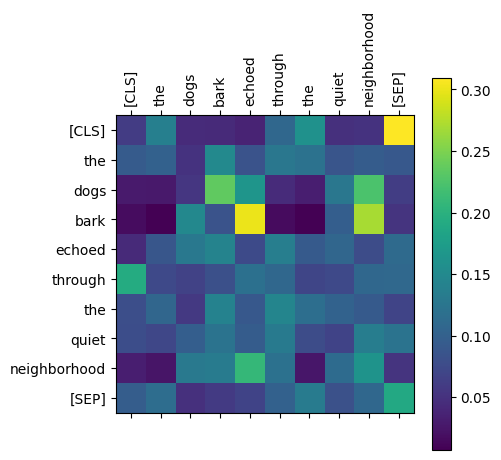

In [32]:
#Process the first sentence
inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
outputs = model(**inputs)
attention = outputs.attentions[0][0, 0, :, :].detach().numpy()  # First layer, first head
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

#Visualization for the first sentence
plt.figure(figsize=(10,10))
plt.matshow(attention, cmap='viridis')
plt.colorbar()
plt.xticks(range(len(tokens)), tokens, rotation='vertical')
plt.yticks(range(len(tokens)), tokens)
plt.show()

<Figure size 1000x1000 with 0 Axes>

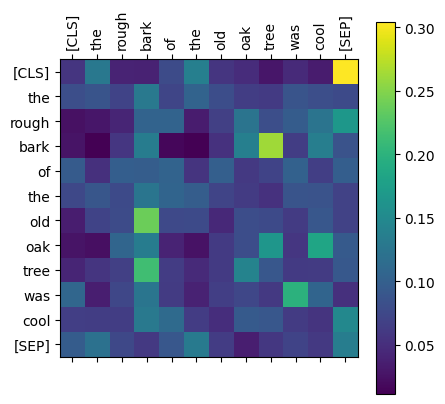

In [33]:
#Process the second sentence
inputs = tokenizer(text2, return_tensors="pt", padding=True, truncation=True, max_length=128)
outputs = model(**inputs)
attention = outputs.attentions[0][0, 0, :, :].detach().numpy()  # First layer, first head
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

#Visualization for the second sentence
plt.figure(figsize=(10,10))
plt.matshow(attention, cmap='viridis')
plt.colorbar()
plt.xticks(range(len(tokens)), tokens, rotation='vertical')
plt.yticks(range(len(tokens)), tokens)
plt.show()